## Modeling & Evaluation (Random Forest) Suara Buka Tutup

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import joblib

train_df = pd.read_csv("train_features.csv")
val_df   = pd.read_csv("val_features.csv")

print(f"Data Train: {train_df.shape}, Data Val: {val_df.shape}")
train_df.head()

Data Train: (300, 11), Data Val: (100, 11)


,mean,var,skew,kurt,rms,zcr,centroid,bandwidth,rolloff,entropy,label
0,0.027930,0.054906,0.310139,4.100600,0.235979,0.028975,866.701761,1047.809331,1705.772261,-35.834524,buka
1,0.019298,0.013794,2.706977,16.686246,0.119022,0.035933,1058.185357,1403.849887,1957.563920,-76.693658,buka
2,0.017041,0.014366,2.951589,18.952388,0.121064,0.035234,1089.114505,1429.448068,2157.235440,-79.108993,buka
3,0.022818,0.016513,2.394192,12.646443,0.130515,0.044334,811.369504,1156.557667,1385.465865,-65.200230,buka
4,0.026553,0.054825,0.299643,4.157365,0.235648,0.028797,963.396500,1217.603421,1896.634743,-36.362223,buka


In [2]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']

X_val = val_df.drop(columns=['label'])
y_val = val_df['label']

In [3]:
rf_model = RandomForestClassifier(
    n_estimators=200,      # jumlah pohon
    max_depth=None,        # biarkan pohon tumbuh penuh
    random_state=42,
    n_jobs=-1             
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [5]:
y_pred = rf_model.predict(X_val)

acc = accuracy_score(y_val, y_pred)
print(f"Akurasi Model Random Forest: {acc*100:.2f}%\n")

print("=== Classification Report ===")
print(classification_report(y_val, y_pred))

joblib.dump(rf_model, 'model_results/rf_model_buka_tutup.pkl')

Akurasi Model Random Forest: 94.00%

=== Classification Report ===
              precision    recall  f1-score   support

        buka       0.89      1.00      0.94        50
       tutup       1.00      0.88      0.94        50

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100



['model_results/rf_model_buka_tutup.pkl']

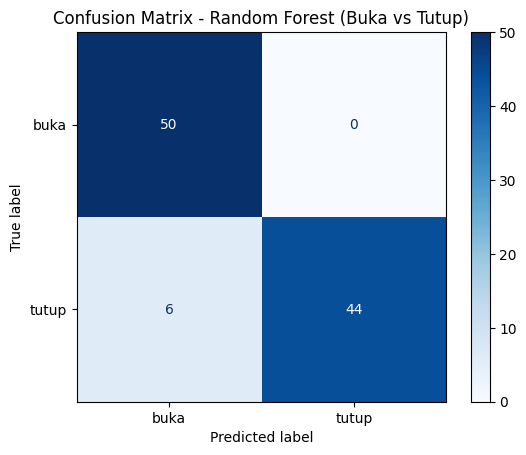

In [6]:
# Confusion Matrix
cm = confusion_matrix(y_val, y_pred, labels=rf_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest (Buka vs Tutup)")
plt.show()

/tmp/ipykernel_6116/1959887399.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=importances.index, palette='mako')


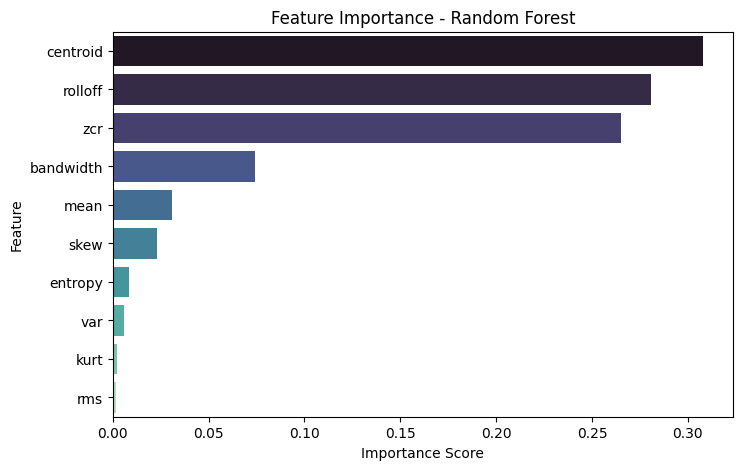

In [7]:
importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=importances.index, palette='mako')
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [8]:
import os
import librosa
import numpy as np
import pandas as pd
from scipy import stats
import IPython.display as ipd

In [9]:
def find_audio_file():
    buka_folder = "dataset48k/val/buka/"

    if os.path.exists(buka_folder):
        audio_files = [f for f in os.listdir(buka_folder) if f.endswith('.wav')]
        if audio_files:
            return os.path.join(buka_folder, audio_files[49])
    return None

test_file = find_audio_file()

rf_models = joblib.load('model_results/rf_model_buka_tutup.pkl')

if test_file is None:
    print("Tidak ada file audio yang ditemukan!")
    
else:
    print(f"Menggunakan file: {test_file}")
    
    ipd.display(ipd.Audio(test_file))
    # Preprocess
    y, sr = librosa.load(test_file, sr=22050)
    
    # durasi tidak lebih dari 1 detik
    max_len = int(sr * 1.0)
    if len(y) < max_len:
        y = np.pad(y, (0, max_len - len(y)), mode='constant')
    else:
        y = y[:max_len]
    
    y = y / np.max(np.abs(y) + 1e-6)

    # Ekstraksi fitur tunggal
    feat = {
        "mean": np.mean(y),
        "var": np.var(y),
        "skew": stats.skew(y),
        "kurt": stats.kurtosis(y),
        "rms": np.sqrt(np.mean(y**2)),
        "zcr": np.mean(librosa.feature.zero_crossing_rate(y)),
        "centroid": np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)),
        "bandwidth": np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)),
        "rolloff": np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    }
    
    hist, _ = np.histogram(y, bins=50, density=True)
    hist = hist[hist > 0]  
    feat["entropy"] = -np.sum(hist * np.log2(hist + 1e-10))

    X_new = pd.DataFrame([feat])

    pred_label = rf_models.predict(X_new)[0]
    pred_proba = rf_models.predict_proba(X_new)[0]
    
    print(f"\nPrediksi suara file ini adalah: **{pred_label.upper()}**")
    print(f"Confidence: {max(pred_proba)*100:.1f}%")
    print(f"Probabilitas: Buka={pred_proba[0]*100:.1f}%, Tutup={pred_proba[1]*100:.1f}%")

Menggunakan file: dataset48k/val/buka/buka48k-buka_153.wav.wav



Prediksi suara file ini adalah: **BUKA**
Confidence: 76.5%
Probabilitas: Buka=76.5%, Tutup=23.5%
